In [1]:
# import necessary libraries
import numpy as np
import xarray as xr
import datetime as dt
from pathlib import Path
import pandas as pd
import os
import os.path as op
import sys

# data retrieval libraries
import requests
from urllib.request import urlretrieve #used for downloading files
import json
import copernicusmarine

# data processing libraries
from scipy import stats
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from myst_nb import glue #used for figure numbering when exporting to LaTeX

sys.path.append("../../../functions")
from data_downloaders import download_oni_index


ModuleNotFoundError: No module named 'data_downloaders'

In [2]:
data_base_dir = Path('../../../data')
path_figs = "../../../matrix_cc/figures"
data_dir = Path(data_base_dir,'sea_level')


#CHANGE THIS TO YOUR PATH!!
# output_dir = Path('/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/data/output')  # EDIT THIS TO YOUR PATH
output_dir = Path('/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/data/')  # EDIT THIS TO YOUR PATH

# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)


# Also let's just make our figure sizes the same:
plt.rcParams['figure.figsize'] = [10, 4]  # Set a default figure size for the notebook

In [3]:
url = 'https://uhslc.soest.hawaii.edu/data/meta.geojson' #<<--- THIS IS A "HIDDEN" URL (Hard to find by clicking around the website.) 
uhslc_id = 7

#parse this url to get lat/lon of Malakal tide gauge
r = requests.get(url)
data = r.json()
for i in range(len(data['features'])):
    if data['features'][i]['properties']['uhslc_id'] == uhslc_id:
        lat = data['features'][i]['geometry']['coordinates'][1]
        lon = data['features'][i]['geometry']['coordinates'][0]
        station = data['features'][i]['properties']['name']
        country = data['features'][i]['properties']['country']
        break

lat,lon,station, country    

(7.33, 134.463, 'Malakal', 'Palau')

In [4]:
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2022,12,31)

# also save them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

glue("station",station,display=False)
glue("country",country, display=False)
glue("startDateTime",start_date_str, display=False)
glue("endDateTime",end_date_str, display=False)

In [5]:
# Retrieve the EEZ for Palau
import geopandas as gpd
eezPath = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')

# read the shapefile
palau_shp = gpd.read_file(eezPath)
# extract the coordinates of the EEZ
geometry = palau_shp['geometry']

# get the lat and lon of the EEZ
palau_eez = np.array(geometry[0].exterior.coords.xy).T

# get the min and max lat and lon of the EEZ, helpful for obtaining CMEMS data
min_lon = np.min(palau_eez[:,0])
max_lon = np.max(palau_eez[:,0])
min_lat = np.min(palau_eez[:,1])
max_lat = np.max(palau_eez[:,1])

In [6]:
def get_CMEMS_data(data_dir):
        
    maxlat = 15
    minlat = 0
    minlon = 125
    maxlon = 140
    
    start_date_str = "1993-01-01T00:00:00"
    end_date_str = "2023-04-30T23:59:59"
    data_dir = data_dir
    
    """
    Retrieves Copernicus Marine data for a specified region and time period.
    
    Args:
        minlon (float): Minimum longitude of the region.
        maxlon (float): Maximum longitude of the region.
        minlat (float): Minimum latitude of the region.
        maxlat (float): Maximum latitude of the region.
        start_date_str (str): Start date of the data in ISO 8601 format.
        end_date_str (str): End date of the data in ISO 8601 format.
        data_dir (str): Directory to save the retrieved data.
    
    Returns:
        str: The filename of the retrieved data.
    """
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
        variables=["adt", "sla"],
        minimum_longitude=minlon,
        maximum_longitude=maxlon,
        minimum_latitude=minlat,
        maximum_latitude=maxlat,
        start_datetime=start_date_str,
        end_datetime=end_date_str,
        output_directory=data_dir,
        output_filename="cmems_L4_SSH_0.125deg_" + start_date_str[0:4] + "_" + end_date_str[0:4] + ".nc"
    )

In [7]:
fname_cmems = 'cmems_L4_SSH_0.125deg_1993_2023.nc'

# check if the file exists, if not, download it
if not os.path.exists(data_dir / fname_cmems):
    print('You will need to download the CMEMS data in a separate script')
    get_CMEMS_data(data_dir) #<<--- COMMENT OUT TO AVOID ACCIDENTAL DATA DOWNLOADS.
else:
    print('CMEMS data already downloaded, good to go!')

# open the CMEMS data
ds = xr.open_dataset(data_dir / fname_cmems)

# slice the data to time 1993-01-01 to 2022-12-31
ds = ds.sel(time=slice(start_date, end_date))
ds


CMEMS data already downloaded, good to go!


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 10957, latitude: 120, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 480B 0.0625 0.1875 0.3125 ... 14.81 14.94
  * longitude  (longitude) float32 480B 125.1 125.2 125.3 ... 139.7 139.8 139.9
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31
Data variables:
    adt        (time, latitude, longitude) float64 1GB ...
    sla        (time, latitude, longitude) float64 1GB ...
Attributes:
    contact:                   servicedesk.cmems@mercator-ocean.eu
    source:                    Altimetry measurements
    history:                   2024-10-23 12:55:06Z: Creation
    references:                http://marine.copernicus.eu
    comment:                   Sea Surface Height measured by Altimetry and d...
    Conventions:               CF-1.6
    institution:               CLS, CNES
    title:                     DT merged all satellites Global Ocean Gridded ...
    copernicusmarine_version:  2.0.0a4

In [8]:
uhslc_id = 7
fname = f'h{uhslc_id:03}.nc' # h for hourly, d for daily

url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/" 

path = os.path.join(data_dir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path) 

    
rsl = xr.open_dataset(path)

# extract the station name
rsl['station_name'] = rsl['station_name'].str.decode('utf-8')

station_name = rsl['station_name'].values[0]
rsl

<xarray.Dataset> Size: 6MB
Dimensions:               (record_id: 1, time: 486849)
Coordinates:
  * time                  (time) datetime64[ns] 4MB 1969-05-18T15:00:00 ... 2...
  * record_id             (record_id) int16 2B 70
Data variables:
    sea_level             (record_id, time) float32 2MB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) <U7 28B 'Malakal'
    station_country       (record_id) |S5 5B ...
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-01-27T14:35:24Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [9]:
# Extract the data for the period of record (POR)
tide_gauge_data_POR = rsl['sea_level'].sel(time=slice(start_date, end_date))

# Convert to meters and drop any NaN values
tide_gauge_data_meters = tide_gauge_data_POR / 1000  # Convert from mm to meters
tide_gauge_data_clean = tide_gauge_data_meters.dropna(dim='time')

# Resample the tide gauge data to daily mean before subtracting the epoch mean
tide_gauge_daily_avg = tide_gauge_data_clean.resample(time='1D').mean()

# Normalize the data relative to the 1993-2012 epoch
epoch_start, epoch_end = start_date, '2011-12-31'
epoch_daily_avg = tide_gauge_daily_avg.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean = epoch_daily_avg.mean()

# Subtract the epoch daily mean from the tide gauge daily average
rsl_daily = tide_gauge_daily_avg - epoch_daily_mean

# Set the attributes of the rsl_daily data
rsl_daily.attrs = tide_gauge_data_POR.attrs
rsl_daily.attrs['units'] = 'm'
rsl_daily.attrs['record_id'] = rsl_daily.coords['record_id'].values[0]

# Remove the 'record_id' dimension
rsl_daily = rsl_daily.drop('record_id')

# Remove any singleton dimensions
rsl_daily = rsl_daily.squeeze()

rsl_daily

/var/folders/88/z9xxhn052qddjc_ppp2j_8gr0000gn/T/ipykernel_81910/3381415331.py:25: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  rsl_daily = rsl_daily.drop('record_id')


<xarray.DataArray 'sea_level' (time: 10957)> Size: 44kB
array([-0.12749314, -0.1223681 , -0.16636801, ...,  0.07934022,
        0.09979868, -0.28803468], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31
Attributes:
    long_name:  relative sea level
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    record_id:  70

In [10]:
# Normalize tide gauge data to CMEMS 1993-2012 epoch
epoch_daily_mean_cmems = ds['sla'].sel(
    time=slice(epoch_start, epoch_end)
).sel(
    longitude=lon, latitude=lat, method='nearest'
).mean(dim='time')

formatted_mean = format(epoch_daily_mean_cmems.values, ".2f")

# Print the mean with a note to re-check source data
print(
    f'The mean for the [1993,2012] epoch of the SLA is {formatted_mean} m. '
    'Re-check source data to make sure this is correct.'
)

The mean for the [1993,2012] epoch of the SLA is 0.02 m. Re-check source data to make sure this is correct.


In [11]:
sla = ds['sla'].sel(time=slice(start_date, end_date))
time_cmems = pd.to_datetime(sla['time'].values)

# Extract data for the nearest point to the tide gauge location
sla_nearest = sla.sel(longitude=lon, latitude=lat, method='nearest')

sla_nearest_lat = sla_nearest['latitude'].values
sla_nearest_lon = sla_nearest['longitude'].values

# Format lat lon strings to have decimal symbol and N/S and E/W
lat_str = f'{np.abs(sla_nearest_lat):.3f}\u00B0{"N" if sla_nearest_lat > 0 else "S"}'
lon_str = f'{np.abs(sla_nearest_lon):.3f}\u00B0{"E" if sla_nearest_lon > 0 else "W"}'

print(f'The closest altimetry grid point is {lat_str}, {lon_str}')
sla_nearest

The closest altimetry grid point is 7.312°N, 134.438°E


<xarray.DataArray 'sla' (time: 10957)> Size: 88kB
[10957 values with dtype=float64]
Coordinates:
    latitude   float32 4B 7.312
    longitude  float32 4B 134.4
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31
Attributes:
    standard_name:  sea_surface_height_above_sea_level
    units:          m
    long_name:      Sea level anomaly

In [12]:
def add_zebra_frame(ax, lw=2, segment_length=0.5, crs=ccrs.PlateCarree()):
    # Get the current extent of the map
    left, right, bot, top = ax.get_extent(crs=crs)

    # Calculate the nearest 0 or 0.5 degree mark within the current extent
    left_start = left - left % segment_length
    bot_start = bot - bot % segment_length

    # Adjust the start if it does not align with the desired segment start
    if left % segment_length >= segment_length / 2:
        left_start += segment_length
    if bot % segment_length >= segment_length / 2:
        bot_start += segment_length

    # Extend the frame slightly beyond the map extent to ensure full coverage
    right_end = right + (segment_length - right % segment_length)
    top_end = top + (segment_length - top % segment_length)

    # Calculate the number of segments needed for each side
    num_segments_x = int(np.ceil((right_end - left_start) / segment_length))
    num_segments_y = int(np.ceil((top_end - bot_start) / segment_length))

    # Draw horizontal stripes at the top and bottom
    for i in range(num_segments_x):
        color = 'black' if (left_start + i * segment_length) % (2 * segment_length) == 0 else 'white'
        start_x = left_start + i * segment_length
        end_x = start_x + segment_length
        ax.hlines([bot, top], start_x, end_x, colors=color, linewidth=lw, transform=crs)

    # Draw vertical stripes on the left and right
    for j in range(num_segments_y):
        color = 'black' if (bot_start + j * segment_length) % (2 * segment_length) == 0 else 'white'
        start_y = bot_start + j * segment_length
        end_y = start_y + segment_length
        ax.vlines([left, right], start_y, end_y, colors=color, linewidth=lw, transform=crs)


Text(134.4375, 7.362500190734863, 'Nearest Altimetry \n Grid Point')

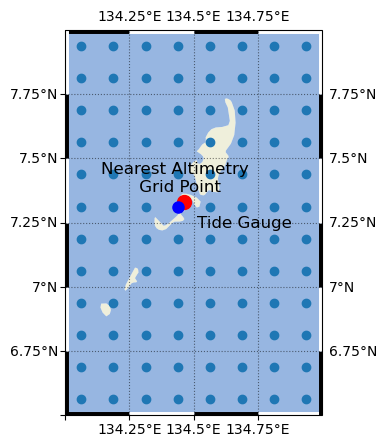

In [13]:
# Set up the map projection
crs = ccrs.PlateCarree()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': crs})
# Set map limits
xmin, xmax, ymin, ymax = 134, 135, 6.5, 8
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# add the land and ocean features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add the tide gauge location
ax.plot(lon, lat, marker='o', color='red', markersize=10, transform=crs)

# Add the altimetry grid point
ax.plot(sla_nearest_lon, sla_nearest_lat, marker='o', 
        color='blue', markersize=8, transform=crs)

# Create 2D arrays of the longitude and latitude values
lon2d, lat2d = np.meshgrid(sla.longitude, sla.latitude)

# plot the latitude and longitude values
ax.scatter(lon2d, lat2d, transform=crs)

# Set custom ticks for the zebra frame
degree_interval = 0.25
ax.set_xticks(np.arange(xmin,xmax,degree_interval), crs=crs)
ax.set_yticks(np.arange(ymin,ymax,degree_interval), crs=crs)
ax.set_xticklabels([]), ax.set_yticklabels([])

# Call the function to add the zebra frame
add_zebra_frame(ax, lw=5, segment_length=0.25, crs=crs)

# add map grid
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())

# Add the tide gauge location with callout text
tide_gauge_label = "Tide Gauge"
ax.text(lon+0.05, lat-0.05, tide_gauge_label, 
        transform=crs, ha='left',va = 'top', fontsize=12)

# Add the altimetry grid point with callout text
altimetry_label = "Nearest Altimetry \n Grid Point"
ax.text(sla_nearest_lon, sla_nearest_lat+0.05, altimetry_label, 
        transform=crs, ha='center', va = 'bottom', fontsize=12)


(np.float64(8401.0), np.float64(19357.0))

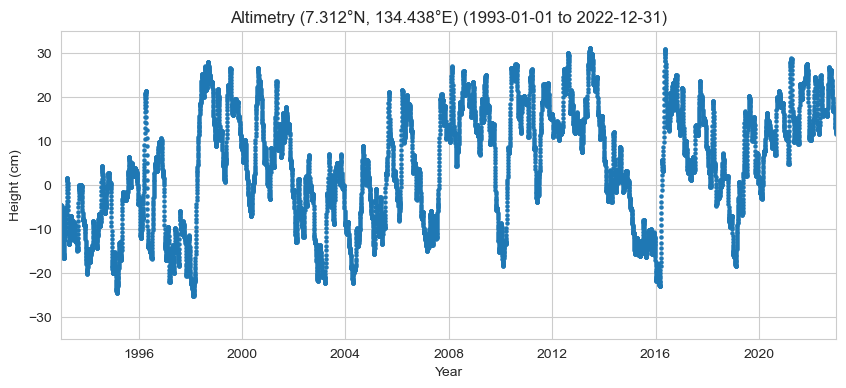

In [14]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Paired")

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data

# plot altimetry data
ax.scatter(sla_nearest['time'], 100*sla_nearest, label='Altimetry', color=palette[1], alpha=1, s= 5)

# Set the title and labels
ax.set_title(f'Altimetry ({lat_str}, {lon_str}) ({start_date_str} to {end_date_str})')
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm)')

# Set the y limits
ax.set_ylim([-35, 35])

# Set the x limits
ax.set_xlim([start_date, end_date])


In [15]:
import statsmodels.api as sm
from joblib import Parallel, delayed

def process_trend_with_nan(sea_level_anomaly,n_jobs=1):
    
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    trend_rates = np.full(sla_flat.shape[1], fill_value=np.nan)
    p_values = np.full(sla_flat.shape[1], fill_value=np.nan)

    def compute_trend(y,i):
        mask = ~np.isnan(y) 
        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]
            slope, intercept, r_value, p_value, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept
            return slope, trend, p_value
        return np.nan, np.nan
    
    #run in parallel
    results = Parallel(n_jobs=n_jobs)(delayed(compute_trend)(sla_flat[:,i],i) for i in range(sla_flat.shape[1]))
    trend_rates, p_values = zip(*results)

    #convert to numpy arrays
    trend_rates = np.array(trend_rates)
    p_values = np.array(p_values)

    # compute magnitude of trend
    sea_level_trend = np.outer(time_index, trend_rates)
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    # compute time magnitude
    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    # compute trend rate
    trend_rate = trend_mag / time_mag

    trend_mag= xr.DataArray(trend_mag, coords=[("latitude", sla.latitude), ("longitude", sla.longitude)])
    trend_rate= xr.DataArray(trend_rate, coords=[("latitude", sla.latitude), ("longitude", sla.longitude)])
    sea_level_trend = xr.DataArray(sea_level_trend, coords=[("time", sea_level_anomaly.time), ("latitude", sla.latitude), ("longitude", sla.longitude)])

    return trend_mag, sea_level_trend, trend_rate, np.nanmean(p_values)


    # # Loop over each grid point
    # for i in range(sla_flat.shape[1]):
    #     # Get the time series for this grid point
    #     y = sla_flat[:,i]
    #     mask = ~np.isnan(y)

    #     detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    #     trend_rates = []
    #     p_values = []

    #     if np.any(mask):
    #         time_masked = time_index[mask]
    #         y_masked = y[mask]

    #         X = sm.add_constant(time_masked)
    #         model = sm.OLS(y_masked, X).fit(cov_type='nonrobust')

    #         trend = model.params[1] * time_index + model.params[0]
    #         detrended_flat[:, i] = y - trend

    #         trend_rates.append(model.params[1])  # Extract the slope
    #         p_values.append(model.pvalues[1])  # Corrected p-value

    #         # slope, intercept, r_value, p_value, _ = stats.linregress(time_masked, y_masked)
    #         # trend = slope * time_index + intercept

    #         detrended_flat[:,i] = y - trend

    # detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # # Calculate trend magnitude
    # sea_level_trend = sea_level_anomaly - detrended
    # trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    # times = pd.to_datetime(sea_level_anomaly['time'].values)
    # time_mag = (times[-1] - times[0]).days/365.25 # in years

    # trend_rate = trend_mag / time_mag


    # return trend_mag, sea_level_trend, trend_rate , np.mean(p_values) # corrected p-value

In [16]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    detrended_flat_err = np.full_like(sla_flat, fill_value=np.nan)
    trend_rates = np.full(sla_flat.shape[1], np.nan)
    trend_errors = np.full(sla_flat.shape[1], np.nan)
    p_values = np.full(sla_flat.shape[1], np.nan)



    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, p_value, std_error = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend
            trend_rates[i] = slope
            trend_errors[i] = std_error
            p_values[i] = p_value

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)
    trend_errors_reshaped = trend_errors.reshape(sea_level_anomaly.shape[1:])

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag
    trend_err = trend_errors_reshaped / time_mag

    return trend_mag, sea_level_trend, trend_rate, np.nanmean(p_value) , np.nanmean(trend_err)

In [17]:
trend_mag_cmems, trend_line_cmems, trend_rate_cmems, p_value_cmems, trend_err_cmems = process_trend_with_nan(sla)

trend_mag_asl, trend_line_asl, trend_rate_asl, p_value_asl,trend_err_asl = process_trend_with_nan(sla_nearest)

In [18]:
trend_err_asl

np.float64(1.2337571092711872e-08)

In [19]:
# calculate the area weights as cosine of latitude
# For a rectangular grid, this is equivalent to multiplying by the grid cell area
weights = np.cos(np.deg2rad(sla.latitude))
weights.name = "weights"

# apply weights to the trend data
trend_mag_weighted = trend_mag_cmems.weighted(weights)

# calculate the regional mean
trend_mag_regional = trend_mag_weighted.mean(dim=('latitude', 'longitude'))

# prepare the output string
output = (
    'The regional magnitude of sea level change is {:.2f} cm for the time '
    'period bounded by {} and {}.'
).format(100*trend_mag_regional.values, start_date_str, end_date_str)

print(output)

The regional magnitude of sea level change is 15.33 cm for the time period bounded by 1993-01-01 and 2022-12-31.


In [20]:
def plot_map(vmin, vmax, xlims, ylims):
    """
    Plot a map of the magnitude of sea level change.

    Parameters:
    vmin (float): Minimum value for the color scale.
    vmax (float): Maximum value for the color scale.
    xlims (tuple): Tuple of min and max values for the x-axis limits.
    ylims (tuple): Tuple of min and max values for the y-axis limits.

    Returns:
    fig (matplotlib.figure.Figure): The matplotlib figure object.
    ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes object.
    crs (cartopy.crs.Projection): The cartopy projection object.
    cmap (matplotlib.colors.Colormap): The colormap used for the plot.
    """
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': crs})
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    palette = sns.color_palette("mako_r", as_cmap=True)
    cmap = palette

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')

    return fig, ax, crs, cmap

def plot_zebra_frame(ax, lw=5, segment_length=2, crs=ccrs.PlateCarree()):
    """
    Plot a zebra frame on the given axes.

    Parameters:
    - ax: The axes object on which to plot the zebra frame.
    - lw: The line width of the zebra frame. Default is 5.
    - segment_length: The length of each segment in the zebra frame. Default is 2.
    - crs: The coordinate reference system of the axes. Default is ccrs.PlateCarree().
    """
    # Call the function to add the zebra frame
    add_zebra_frame(ax=ax, lw=lw, segment_length=segment_length, crs=crs)
    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

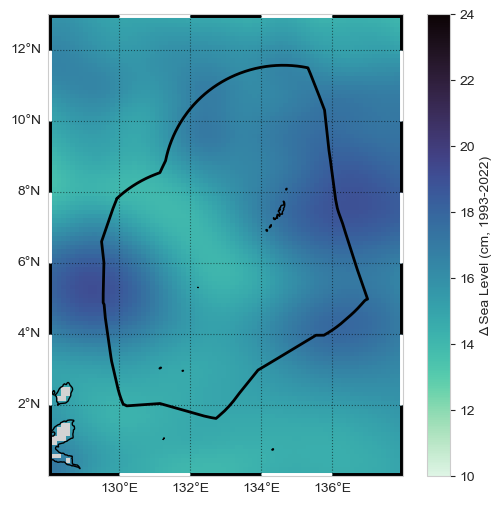

In [21]:

xlims = [128, 138]
ylims = [0, 13]
vmin, vmax = 10, 24
# vmin, vmax = 

fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)

# plot the trend*100 for centimeters
trend_mag_cmems_cm = trend_mag_cmems * 100

# plot a map of the magnitude of SL change in centimeters
trend_mag_cmems_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Δ Sea Level (cm, 1993-2022)'},
)

# add the EEZ
ax.plot(palau_eez[:, 0], palau_eez[:, 1], transform=crs, color='black', linewidth=2)


# Call the function to add the zebra frame
plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)
plt.savefig(op.join(path_figs, 'F10_SeaLevel_map.png'), dpi=300, bbox_inches='tight')



Text(0.95, 0.05, 'Δ Sea Level: 17.34 cm, Trend: 0.58 cm/year')

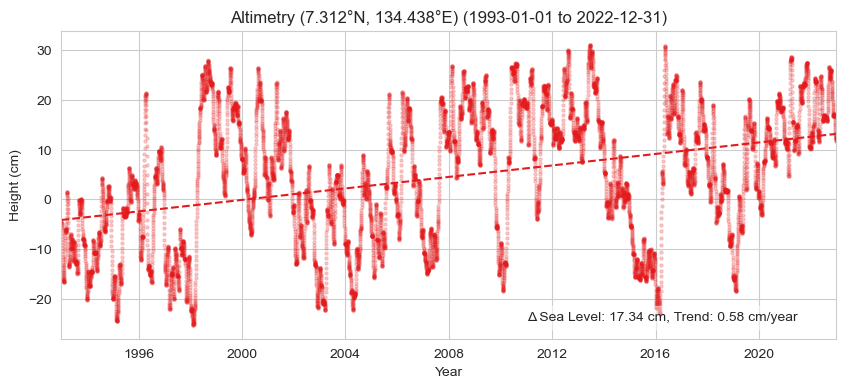

In [22]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()

# plot altimetry data
ax.scatter(sla_nearest['time'], 100*sla_nearest, label='Altimetry', 
           color=palette[0], alpha=0.2, s=5)
ax.plot(time_cmems, 100*trend_line_asl, label='Altimetry Trend', 
        color=palette[0], linestyle='--')

# Set the title and labels
title = f'Altimetry ({lat_str}, {lon_str}) ({start_date_str} to {end_date_str})'
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm)')

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = (f'Δ Sea Level: {100*trend_mag_asl:.2f} cm, '
                f'Trend: {100*trend_rate_asl:.2f} cm/year')

# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(facecolor='white', alpha=0.5))

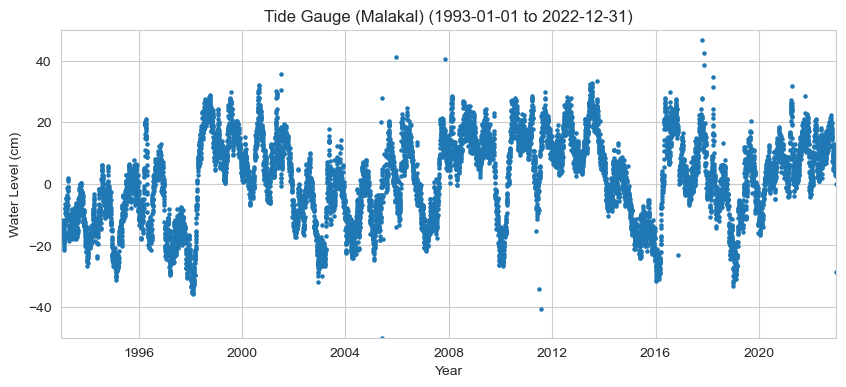

In [23]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Paired")

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data

# plot tide gauge data
ax.scatter(rsl_daily['time'],100*rsl_daily, label='RSL', 
           color=palette[1], alpha=1, s= 5)

# Set the title, labels, and limits
ax.set(
    title=f'Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})',
    xlabel='Year',
    ylabel='Water Level (cm)',
    ylim=[-50, 50],
    xlim=[start_date, end_date]
);



In [24]:
# calculate the rate of change for the tide gauge
trend_mag_rsl, trend_line_rsl, trend_rate_rsl, p_value_rsl, trend_err_rsl = process_trend_with_nan(rsl_daily)

print(f'The trend magnitude for the tide gauge is {100*trend_mag_rsl:.2f} cm.')
print(f'The trend rate for the tide gauge is {100*trend_rate_rsl:.2f} cm/year.')

The trend magnitude for the tide gauge is 12.26 cm.
The trend rate for the tide gauge is 0.41 cm/year.


Text(0.95, 0.05, 'Δ Sea Level: 12.26 cm, Trend: 0.41 cm/year')

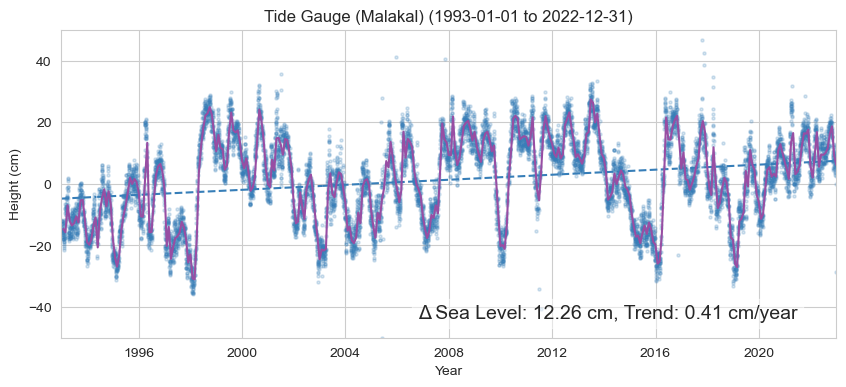

In [25]:
# make an rsl monthly mean for plotting
rsl_monthly = rsl_daily.resample(time='1ME').mean().squeeze()

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()
# plot altimetry data
ax.scatter(rsl_daily['time'], 100*rsl_daily, 
           label='Tide Gauge', color=palette[1], alpha=0.2, s= 5)
ax.plot(rsl_daily['time'], 100*trend_line_rsl, 
        label='Tide Gauge Trend', color=palette[1], linestyle='--')
# plot the monthly mean sea level
ax.plot(rsl_monthly['time'], 100*rsl_monthly, 
        label='Tide Gauge', color=palette[3])


# Set the title and labels
ax.set_title(f'Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})')
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm)')

# Set the y limits
ax.set_ylim([-50, 50])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = f'Δ Sea Level: {100*trend_mag_rsl:.2f} cm, Trend: {100*trend_rate_rsl:.2f} cm/year'
# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        fontsize=14, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5))


In [26]:

# Constants
DATA_SOURCE_ALTIMETRY = 'CMEMS SSH L4 0.125 deg (SLA)'
DATA_SOURCE_TIDE_GAUGE = 'UHSLC RQDS'
TIME_PERIOD = f'{start_date_str} to {end_date_str}'

# Calculated values 
trend_mmyr_altimetry = 1000 * trend_rate_asl.values
trend_mmyr_tide_gauge = 1000 * trend_rate_rsl.values
delta_sea_level_altimetry = 100 * trend_mag_asl.values
delta_sea_level_tide_gauge = 100 * trend_mag_rsl.values


# Create DataFrame
SL_magnitude_results = pd.DataFrame({
    'Trend (mm/yr)': [trend_mmyr_altimetry, trend_mmyr_tide_gauge],
    'Trend (in/yr)': [trend_mmyr_altimetry * 0.0393701, trend_mmyr_tide_gauge * 0.0393701],
    'Δ Sea Level (cm)': [delta_sea_level_altimetry, delta_sea_level_tide_gauge],
    'Δ Sea Level (in)': [delta_sea_level_altimetry * 0.393701, delta_sea_level_tide_gauge * 0.393701],
    'Latitude': [sla_nearest_lat, rsl['lat'].values[0]],
    'Longitude': [sla_nearest_lon, rsl['lon'].values[0]],
    'Time_Period': [TIME_PERIOD, TIME_PERIOD],
    'Data_Source': [DATA_SOURCE_ALTIMETRY, DATA_SOURCE_TIDE_GAUGE],
}, index=['Altimetry', 'Tide Gauge'])

# Save to CSV
output_file_path = output_dir / 'SL_magnitude_results.csv'

# Use the path for operations, e.g., saving a DataFrame
SL_magnitude_results.to_csv(output_file_path)

# glue trend_rates to the notebook
# glue("trend_rate_rsl", trend_rate_rsl, display=False)
# glue("trend_rate_asl", trend_rate_asl, display=False)




SL_magnitude_results



,Trend (mm/yr),Trend (in/yr),Δ Sea Level (cm),Δ Sea Level (in),Latitude,Longitude,Time_Period,Data_Source
Altimetry,5.779614,0.227544,17.336469,6.825385,7.3125,134.4375,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.125 deg (SLA)
Tide Gauge,4.086637,0.160891,12.258233,4.826078,7.33,134.462997,1993-01-01 to 2022-12-31,UHSLC RQDS


In [27]:
# glue all table values to the notebook (trend rates etc)

glue("trend_mmyr_altimetry", trend_mmyr_altimetry, display=False)
glue("trend_inyr_altimetry", trend_mmyr_altimetry * 0.0393701, display=False)
glue("trend_mmyr_tide_gauge", trend_mmyr_tide_gauge, display=False)
glue("trend_inyr_tide_gauge", trend_mmyr_tide_gauge * 0.0393701, display=False)
glue("delta_cm_altimetry", delta_sea_level_altimetry, display=False)
glue("delta_in_altimetry", delta_sea_level_altimetry * 0.393701, display=False)
glue("delta_cm_tide_gauge", delta_sea_level_tide_gauge, display=False)
glue("delta_in_tide_gauge", delta_sea_level_tide_gauge * 0.393701, display=False)

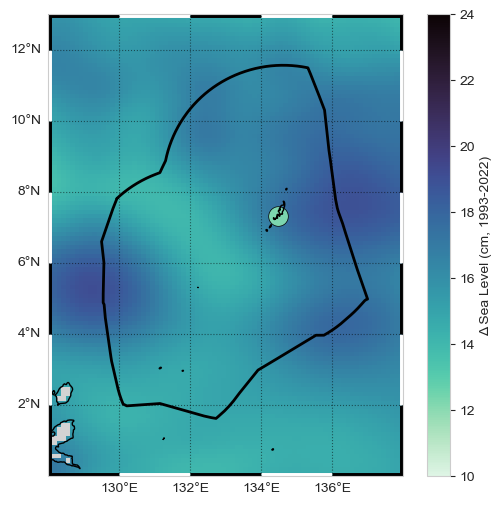

In [28]:
fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)

# plot the trend*100 for centimeters
trend_mag_cmems_cm = trend_mag_cmems * 100

# plot a map of the magnitude of SL change in centimeters
trend_mag_cmems_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Δ Sea Level (cm, 1993-2022)'},
)

# add the EEZ
ax.plot(palau_eez[:, 0], palau_eez[:, 1], transform=crs, color='black', linewidth=2)
# add the tide gauge location with black outlined dot, colored by the sea level value
ax.scatter(rsl['lon'], rsl['lat'], transform=crs, s=200, 
           c=100*trend_mag_rsl, vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black')

plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)

glue("mag_fig", fig, display=False)

# save the figure
output_file_path = output_dir / 'SL_magnitude_map.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')

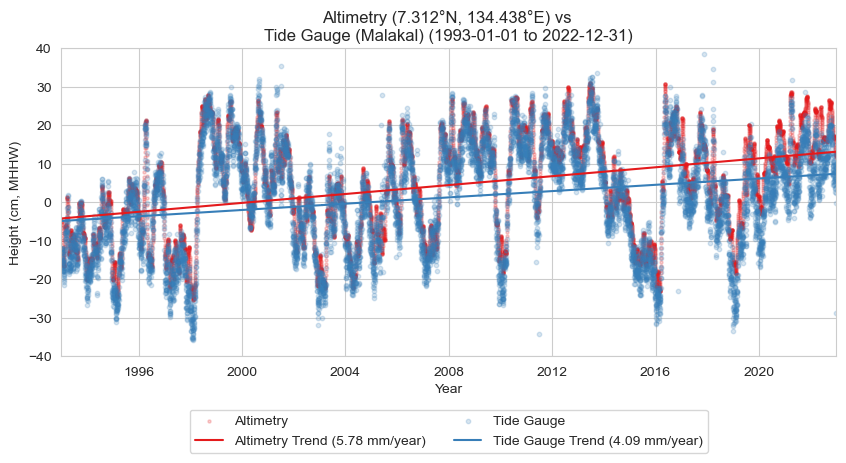

In [29]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Create the figure and the axes
fig, ax = plt.subplots()

# plot altimetry data
labelSat = f'Altimetry Trend ({1000*trend_rate_asl:.2f} mm/year)'
ax.scatter(sla_nearest['time'], 100*sla_nearest, 
           label='Altimetry', color=palette[0], alpha=0.2, s=5)
ax.plot(sla_nearest['time'], 100*trend_line_asl, 
        label=labelSat, color=palette[0], linestyle='-')

# plot tide gauge data
labelTG = f'Tide Gauge Trend ({1000*trend_rate_rsl:.2f} mm/year)'
ax.scatter(rsl_daily['time'], 100*rsl_daily, 
           label='Tide Gauge', color=palette[1], alpha=0.2, s=10)
ax.plot(rsl_daily['time'], 100*trend_line_rsl, 
        label=labelTG, color=palette[1], linestyle='-')

# Set the title and labels
title = (
    f'Altimetry ({lat_str}, {lon_str}) vs \n'
    f'Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})'
)
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm, MHHW)')

# Set the y and x limits
ax.set_ylim([-40, 40])
ax.set_xlim([start_date, end_date])

# Add a legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

glue("trend_fig", fig, display=False)

# save the figure
output_file_path = output_dir / 'SL_magnitude_timeseries.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.savefig(op.join(path_figs, 'F10_SeaLevel_trends.png'), dpi=300, bbox_inches='tight')


In [30]:
# add nino
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
oni = download_oni_index(p_data)

/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/notebooks_historical/ocean/1_sea_level/../../../functions/data_downloaders.py:242: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oni = pd.read_csv(


In [31]:
# Remove the trend from the tide gauge timeseries
detrended_rsl = rsl_daily - trend_line_rsl

# estimate the seasonal cycle (detrended_rsl is xarray)
seasonal_cycle = detrended_rsl.groupby('time.dayofyear').mean('time')

# Remove the seasonal cycle from the detrended tide gauge timeseries
deseasoned_rsl = detrended_rsl.groupby('time.dayofyear') - seasonal_cycle

# Resample the ONI index to daily frequency and align with the tide gauge timeseries
oni_daily = oni.resample('D').interpolate(method='linear')
oni_daily = oni_daily.reindex(deseasoned_rsl['time'], method='nearest')

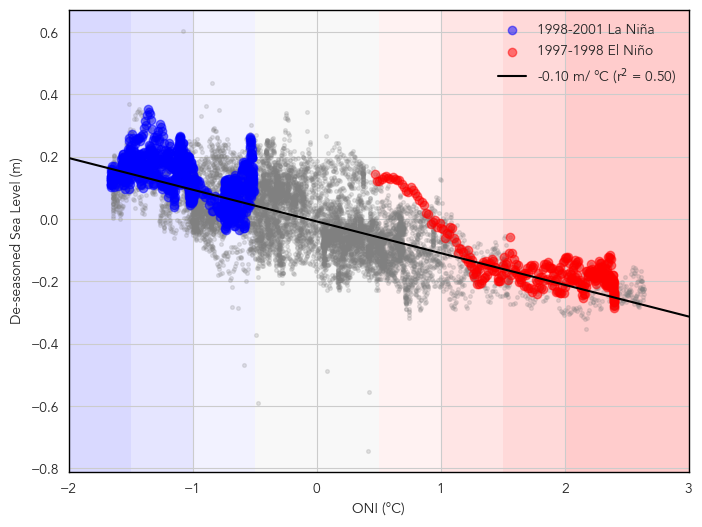

In [32]:
# scatter plot of oni daily and detrended sea level
# Scatter plot of ONI daily and detrended sea level
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(oni_daily, deseasoned_rsl, color='gray', alpha=0.2, s=7)
ax.set_xlabel('ONI (°C)')
ax.set_ylabel('De-seasoned Sea Level (m)')

# Emphasize the 1997-1998 and 2015-2016 El Niño events using pandas indexing
nina_1998 = deseasoned_rsl.sel(time=slice('1998-08-01', '2001-01-30'))
nino_1997 = deseasoned_rsl.sel(time=slice('1997-06-01', '1998-04-30'))

# Plot as dashed lines
ax.scatter(oni_daily.loc['1998-08-01':'2001-01-30'], nina_1998, color='blue', label='1998-2001 La Niña',alpha=0.5)
ax.scatter(oni_daily.loc['1997-06-01':'1998-04-30'], nino_1997, color='red', label='1997-1998 El Niño',alpha=0.5)

# draw a correlation line
# Keep only valid (non-NaN) indices
deseasoned_rsl_series = deseasoned_rsl.to_series()
valid_mask = ~deseasoned_rsl_series.isna()
oni_valid = oni_daily.squeeze().loc[valid_mask]
deseasoned_valid = deseasoned_rsl_series.loc[valid_mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(oni_valid, deseasoned_valid, )
x = np.linspace(-2,3,100)
y = slope * x + intercept
ax.plot(x, y, color='black', linestyle='-', label=f'{slope:.2f} m/ °C (r$^2$ = {r_value**2:.2f})')

ax.set_xlim(-2,3)
ax.legend(frameon=False)
# Add shading for different ONI ranges


ax.axvspan(-2, -1.5, color='blue', alpha=0.15, linewidth=0, zorder=0)
ax.axvspan(-1.5, -1, color='blue', alpha=0.10, linewidth=0, zorder=0)
ax.axvspan(-1, -0.5, color='blue', alpha=0.05, linewidth=0, zorder=0)
ax.axvspan(-0.5, 0.5, color='gray', alpha=0.05, linewidth=0, zorder=0)
ax.axvspan(0.5, 1, color='red', alpha=0.05, linewidth=0, zorder=0)
ax.axvspan(1, 1.5, color='red', alpha=0.10, linewidth=0, zorder=0)
ax.axvspan(1.5, 2, color='red', alpha=0.15, linewidth=0, zorder=0)
ax.axvspan(2, 3, color='red', alpha=0.20, linewidth=0, zorder=0)


# spines should be black not gray

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# set all text to avenir
for text in ax.texts:
    text.set_fontname('Avenir')

# set all labels to avenir
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_legend().get_texts() :
    label.set_fontname('Avenir')

ax.xaxis.label.set_fontname('Avenir')
ax.yaxis.label.set_fontname('Avenir')

plt.show()

# save the figure
output_file_path = output_dir / 'SL_ONI_scatter.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')


In [33]:
# Create a DataFrame to summarize the results
summary_data = {
    'Description': ['Slope of Correlation Line', 
                    'El Niño 1997-1998 Min Sea Level', 
                    'El Niño 1997-1998 Median Sea Level',
                    'La Niña 1998-2000 Max Sea Level', 
                    'La Niña 1998-2000 Median Sea Level',
                    'Correlation Coefficient (r)', 
                    'p-value'],
    'Value': [slope, 
              100*nino_1997.min().values,
              100*nino_1997.median().values, 
              100*nina_1998.max().values, 
              100*nina_1998.median().values,
              r_value, 
              p_value],
    'units': ['m/°C', 'cm', 'cm','cm', 'cm', '', '']
}

summary_df = pd.DataFrame(summary_data)

summary_df.attrs['description'] = "Correlation of Sea Level at Malakal with ONI 1983-2024."
summary_df.attrs['source'] = "NOAA / University of Hawaii Sea Level Center"
summary_df.attrs['notes'] = "Sea level data has been deseasoned and detrended."

# Display the summary table with attributes

# Function to format values with units
def format_with_units(value, unit):
    if pd.isna(value):  # Handle NaNs
        return "N/A"
    if unit:  # Add unit only if it's not an empty string
        return f"{value:.2f} {unit}"
    return f"{value:.2f}"  # No unit, just the value

# Apply formatting
summary_df['Formatted'] = summary_df.apply(lambda row: format_with_units(row['Value'], row['units']), axis=1)

# Keep only needed columns (remove 'Value' and 'units' separately)
formatted_df = summary_df[['Description', 'Formatted']].rename(columns={'Formatted': 'Value'})

# Remove index for clean display
formatted_df = formatted_df.reset_index(drop=True)



footer_text = f"Source: {summary_df.attrs['source']}"
notes_text = f"Notes: {summary_df.attrs['notes']}"
footer_df = pd.DataFrame({'Description': [footer_text, notes_text], 
                          'Value': ['','']})

# Combine summary table with footer
summary_table = pd.concat([formatted_df, footer_df], ignore_index=True)  # Removes index completely

# Apply styling
styled_df = summary_table.style.set_caption(
    summary_df.attrs['description']
).set_table_styles([
    {
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]
    },
    {
        'selector': 'tbody tr:last-child td, tbody tr:nth-last-child(2) td',  # Targets last two rows (footer)
        'props': [('font-style', 'italic'), ('font-align', 'center')]
    }
])



# Save the summary table to a CSV file
summary_file_path = output_dir / 'ENSO_SL_influence_summary.csv'
summary_table.to_csv(summary_file_path, index=False)


styled_df

,Description,Value
0,Slope of Correlation Line,-0.10 m/°C
1,El Niño 1997-1998 Min Sea Level,-28.57 cm
2,El Niño 1997-1998 Median Sea Level,-17.74 cm
3,La Niña 1998-2000 Max Sea Level,35.22 cm
4,La Niña 1998-2000 Median Sea Level,13.34 cm
5,Correlation Coefficient (r),-0.71
6,p-value,0.00
7,Source: NOAA / University of Hawaii Sea Level Center,
8,Notes: Sea level data has been deseasoned and detrended.,
